## Red neuronal feed forward/MLP


**Objetivo:** predecir el tipo de movilidad utilizada (walk, train, taxi, etc) utilizada por los usuarios en sus recorridos por medio de la informacion GPS recolectada.


Los datos orginales son de un formato PLT:

* Line 1…6 are useless in this dataset, and can be ignored. Points are described in following lines, one for each line.
* Field 1: Latitude in decimal degrees.
* Field 2: Longitude in decimal degrees.
* Field 3: All set to 0 for this dataset.
* Field 4: Altitude in feet (-777 if not valid).
* Field 5: Date - number of days (with fractional part) that have passed since 12/30/1899.
* Field 6: Date as a string.
* Field 7: Time as a string.


* Number of users: 182
* Number of trajectories: 18,670
* Number of points: 24,876,978
* Total distance: 1,292,951km
* Total duration: 50,176hour

De esta informacion solo se tomo la que esta clasificada en su tipo de ruta.  Adicionalmente se realizo Feature Engineering, para procesar los datos y adecuar la entrada para el modelo MLP. Siendo la estructura inicial del modelo:

* StartDate
* EndDate
* Type
* StarDifAprox
* EndDifAprox
* xStart
* yStart
* xEnd
* yEnd



Referencia del dataset
https://www.microsoft.com/en-us/download/details.aspx?id=52367&from=http%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fdownloads%2Fb16d359d-d164-469e-9fd4-daa38f2b2e13%2F


In [601]:
import numpy as np
import pandas as pd
import datetime
import numpy as np
from datetime import datetime
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [348]:
df = pd.read_csv('../data2x.csv')
df.head(5)

,StartDate,EndDate,Type,StarDifAprox,EndDifAprox,xStart,yStart,xEnd,yEnd
0,6/26/2007 11:32,6/26/2007 11:40,bus,500.000000,500.000000,0.000000,0.000000,0.000000,0.000000
1,3/28/2008 14:52,3/28/2008 15:59,train,4.500000,0.033333,39.893397,116.313677,39.502930,116.714948
2,3/28/2008 16:00,3/28/2008 22:02,train,1.983333,0.683333,39.489695,116.740047,36.671463,116.988268
3,3/29/2008 1:27,3/29/2008 15:59,train,5.383333,0.183333,36.661265,116.956267,34.490502,109.629697
4,3/29/2008 16:00,3/30/2008 15:59,train,1.783333,0.316667,34.495633,109.605400,41.137635,95.465557


In [349]:
df.describe()

,StarDifAprox,EndDifAprox,xStart,yStart,xEnd,yEnd
count,21396.000000,21396.000000,21396.000000,21396.000000,21396.000000,21396.000000
mean,132.254275,127.406345,29.370248,85.682312,29.370248,85.682312
std,219.926409,217.777318,17.450038,51.445871,17.450038,51.445871
min,0.000000,0.000000,0.000000,-122.303127,0.000000,-122.303127
25%,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.166667,0.000000,39.958219,116.328717,39.958219,116.328717
75%,500.000000,500.000000,39.981748,116.406566,39.981748,116.406566
max,500.000000,500.000000,55.835753,174.391982,55.835753,174.391982


Limpieza de datos no validos

In [350]:
valid = df[(df['StarDifAprox']!=500) | (df['EndDifAprox']!=500)]
valid.head(10)

,StartDate,EndDate,Type,StarDifAprox,EndDifAprox,xStart,yStart,xEnd,yEnd
1,3/28/2008 14:52,3/28/2008 15:59,train,4.500000,0.033333,39.893397,116.313677,39.502930,116.714948
2,3/28/2008 16:00,3/28/2008 22:02,train,1.983333,0.683333,39.489695,116.740047,36.671463,116.988268
3,3/29/2008 1:27,3/29/2008 15:59,train,5.383333,0.183333,36.661265,116.956267,34.490502,109.629697
4,3/29/2008 16:00,3/30/2008 15:59,train,1.783333,0.316667,34.495633,109.605400,41.137635,95.465557
5,3/30/2008 16:00,3/31/2008 3:13,train,1.633333,500.000000,41.153458,95.444897,0.000000,0.000000
6,3/31/2008 4:17,3/31/2008 15:31,train,2.883333,0.233333,43.774235,87.586467,41.744755,86.194410
7,3/31/2008 16:00,3/31/2008 16:09,taxi,0.983333,0.000000,41.737063,86.179470,41.758855,86.144468
8,3/31/2008 17:26,4/1/2008 0:35,train,1.383333,0.233333,41.746302,86.192568,41.142970,80.304102
9,4/1/2008 0:48,4/1/2008 0:59,taxi,0.983333,0.000000,41.142140,80.286858,41.169595,80.262703
10,4/1/2008 1:00,4/1/2008 1:08,walk,1.000000,0.000000,41.169568,80.263422,41.170472,80.264645


#### Categorias del dataset

In [351]:
valid.Type.unique()

array(['train', 'taxi', 'walk', 'bus', 'subway', 'airplane', 'car',
       'bike', 'boat', 'run', 'motorcycle'], dtype=object)

In [352]:
def tiempoMin(fec1,fec2):
    val = datetime.datetime.strptime(fec2, '%m/%d/%Y %H:%M') - datetime.datetime.strptime(fec1, '%m/%d/%Y %H:%M')
    val = val.days * 24 *60 + val.seconds/60
    return val

In [353]:
valid['Tiempo'] = valid.apply(lambda row: 
                        tiempoMin(row.StartDate, row.EndDate), 
                        axis = 1)

C:\Users\hecto\AppData\Local\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [354]:
valid

,StartDate,EndDate,Type,StarDifAprox,EndDifAprox,xStart,yStart,xEnd,yEnd,Tiempo
1,3/28/2008 14:52,3/28/2008 15:59,train,4.500000,0.033333,39.893397,116.313677,39.502930,116.714948,67.0
2,3/28/2008 16:00,3/28/2008 22:02,train,1.983333,0.683333,39.489695,116.740047,36.671463,116.988268,362.0
3,3/29/2008 1:27,3/29/2008 15:59,train,5.383333,0.183333,36.661265,116.956267,34.490502,109.629697,872.0
4,3/29/2008 16:00,3/30/2008 15:59,train,1.783333,0.316667,34.495633,109.605400,41.137635,95.465557,1439.0
5,3/30/2008 16:00,3/31/2008 3:13,train,1.633333,500.000000,41.153458,95.444897,0.000000,0.000000,673.0
...,...,...,...,...,...,...,...,...,...,...
21186,7/19/2007 13:36,7/19/2007 13:57,bike,0.400000,0.000000,39.967150,116.344983,39.974933,116.330000,21.0
21187,7/19/2007 13:58,7/19/2007 14:30,walk,2.950000,0.033333,39.966950,116.344900,39.967183,116.344633,32.0
21188,7/20/2007 1:38,7/20/2007 1:40,walk,0.000000,0.000000,39.966333,116.344100,39.965617,116.343750,2.0
21189,7/20/2007 1:40,7/20/2007 1:49,taxi,0.000000,0.000000,39.976950,116.330867,39.966400,116.344233,9.0


In [355]:
# remover columnas no necesarias (explicadas en las notas de feature eng)
del valid["StarDifAprox"] # utilizada en el procesamiento y ya no es necesaria
del valid["EndDifAprox"] # utilizada en el procesamiento y ya no es necesaria

del valid["StartDate"] # Hora inicial se combina con la final para forma tiempo total del viaje
del valid["EndDate"]
valid.head(10)

,Type,xStart,yStart,xEnd,yEnd,Tiempo
1,train,39.893397,116.313677,39.502930,116.714948,67.0
2,train,39.489695,116.740047,36.671463,116.988268,362.0
3,train,36.661265,116.956267,34.490502,109.629697,872.0
4,train,34.495633,109.605400,41.137635,95.465557,1439.0
5,train,41.153458,95.444897,0.000000,0.000000,673.0
6,train,43.774235,87.586467,41.744755,86.194410,674.0
7,taxi,41.737063,86.179470,41.758855,86.144468,9.0
8,train,41.746302,86.192568,41.142970,80.304102,429.0
9,taxi,41.142140,80.286858,41.169595,80.262703,11.0
10,walk,41.169568,80.263422,41.170472,80.264645,8.0


In [356]:
#valid['Type'] = pd.factorize(valid['Type'])[0]

In [357]:
Y = valid[['Type']]
X = valid[['xStart','yStart','xEnd','yEnd','Tiempo']]

In [358]:
# one-hot encoding
labels_hot = pd.get_dummies(Y, prefix='tipo_')
labels_hot

,tipo__airplane,tipo__bike,tipo__boat,tipo__bus,tipo__car,tipo__motorcycle,tipo__run,tipo__subway,tipo__taxi,tipo__train,tipo__walk
1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
21186,0,1,0,0,0,0,0,0,0,0,0
21187,0,0,0,0,0,0,0,0,0,0,1
21188,0,0,0,0,0,0,0,0,0,0,1
21189,0,0,0,0,0,0,0,0,1,0,0


In [359]:
labels_hot.describe()

,tipo__airplane,tipo__bike,tipo__boat,tipo__bus,tipo__car,tipo__motorcycle,tipo__run,tipo__subway,tipo__taxi,tipo__train,tipo__walk
count,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000
mean,0.001614,0.145021,0.000869,0.206109,0.093246,0.000124,0.000497,0.069531,0.050658,0.020363,0.411969
std,0.040145,0.352133,0.029469,0.404522,0.290785,0.011142,0.022281,0.254362,0.219305,0.141241,0.492205
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [361]:
# normalizacion = MinMaxScaler(feature_range=(0, 1))
normalizacion = StandardScaler()
xin = normalizacion.fit_transform(X)
xin

array([[ 0.16566806,  0.14124292,  0.09227285,  0.16388437,  0.24266175],
       [ 0.0897851 ,  0.16530057, -0.43995169,  0.17930628,  3.2859148 ],
       [-0.44186858,  0.17750064, -0.84990206, -0.23589631,  8.54713195],
       ...,
       [ 0.17937774,  0.14295952,  0.17924303,  0.14293977, -0.42788553],
       [ 0.18137333,  0.14221284,  0.17939027,  0.14296704, -0.35567275],
       [ 0.18130128,  0.14219402,  0.18137333,  0.14215171, -0.40725331]])

In [494]:
xin.shape, labels_hot.shape

((16108, 5), (16108, 11))

## MLP

In [629]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras import initializers
from keras import backend as K
tf.__version__

'2.1.0'

In [556]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8604973484605801500
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3059115622
locality {
  bus_id: 1
  links {
  }
}
incarnation: 926748153655774809
physical_device_desc: "device: 0, name: GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:02:00.0, compute capability: 7.5"
]


In [543]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [363]:
cols_input = xx1.shape[1]

Se realizaron diversas pruebas con las funciones de activacion y devido a que se tienen valores negativos en la entrada la funcion **tanh** fue la que genero mejores resultados.

Como inicializacion se esta utilizando Xavier por medio de **RandomNormal**

El **BatchNormalization** 

In [640]:
# Definicion de Aquitectura
mlp1 = Sequential()
mlp1.add(Dense(64,
               input_dim=cols_input, 
               activation='tanh',
               kernel_initializer=initializers.RandomNormal(stddev=0.3),
               #kernel_initializer=initializers.RandomNormal(),
               bias_initializer=initializers.Zeros(),
               name="layer1"))
mlp1.add(BatchNormalization(momentum=0.09, epsilon=0.001))
mlp1.add(Dense(64, activation='tanh',kernel_initializer=initializers.RandomNormal(stddev=0.3),bias_initializer=initializers.Zeros()))
mlp1.add(BatchNormalization(momentum=0.09, epsilon=0.001))
mlp1.add(Dense(64, activation='tanh',kernel_initializer=initializers.RandomNormal(stddev=0.3),bias_initializer=initializers.Zeros()))
mlp1.add(BatchNormalization(momentum=0.09, epsilon=0.001))
mlp1.add(Dense(32, activation='tanh',kernel_initializer=initializers.RandomNormal(stddev=0.1),bias_initializer=initializers.Zeros()))
mlp1.add(BatchNormalization(momentum=0.09, epsilon=0.001))
mlp1.add(Dense(16, activation='tanh',kernel_initializer=initializers.RandomNormal(stddev=0.1),bias_initializer=initializers.Zeros()))
mlp1.add(BatchNormalization(momentum=0.09, epsilon=0.001))
mlp1.add(Dense(11, activation='softmax'))


Para la optimizacion se selecciono **Adam** con una configuracion que se considero que responde mejor a los datos de entrada

El tipo de loss es **Categorical Cross Entropy** debido a que es un problema de clasificacion multiclase y los datos *Y* estan como one-hot encoding 

Se presentan las mediciones de **F1**, **precision** y **recall**

In [650]:
#RMSprop
#adam
#adagrad
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.09)
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#opt = tf.keras.optimizers.Adam(learning_rate=0.0005,amsgrad=True)

mlp1.compile(optimizer='adam',
             #loss = 'categorical_crossentropy',
             loss=tf.keras.losses.CategoricalCrossentropy(
                from_logits=True,
                label_smoothing=0,
                reduction="auto"),
             metrics=['accuracy',f1_m,precision_m, recall_m])

In [651]:
mlp1.summary()

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 64)                384       
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dense_303 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_304 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)                256       
_________________________________________________________________
dense_305 (Dense)            (None, 32)              

In [652]:
resultado = mlp1.fit(xin,labels_hot,validation_split=0.2,epochs=300, verbose=1)


Train on 12886 samples, validate on 3222 samples
Epoch 1/300
12886/12886 [==============================] - 3s 219us/step - loss: 1.9141 - accuracy: 0.6286 - f1_m: 0.6284 - precision_m: 0.6305 - recall_m: 0.6264 - val_loss: 1.9600 - val_accuracy: 0.5872 - val_f1_m: 0.5857 - val_precision_m: 0.5868 - val_recall_m: 0.5846
Epoch 2/300
12886/12886 [==============================] - 2s 174us/step - loss: 1.8921 - accuracy: 0.6509 - f1_m: 0.6510 - precision_m: 0.6525 - recall_m: 0.6495 - val_loss: 1.9326 - val_accuracy: 0.6089 - val_f1_m: 0.6079 - val_precision_m: 0.6093 - val_recall_m: 0.6065
Epoch 3/300
12886/12886 [==============================] - 2s 171us/step - loss: 1.8884 - accuracy: 0.6545 - f1_m: 0.6547 - precision_m: 0.6564 - recall_m: 0.6531 - val_loss: 1.9592 - val_accuracy: 0.5875 - val_f1_m: 0.5875 - val_precision_m: 0.5884 - val_recall_m: 0.5866
Epoch 4/300
12886/12886 [==============================] - 2s 178us/step - loss: 1.8824 - accuracy: 0.6603 - f1_m: 0.6599 - precisio

In [653]:
fechaHora = datetime.now().strftime("%Y%m%d-%H%M%S")
mlp1.save('mlp_' + fechaHora)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\hecto\AppData\Local\Programs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-653-994b4c9dd8e1>", line 2, in <module>
    mlp1.save('mlp_' + fechaHora)
  File "C:\Users\hecto\AppData\Local\Programs\Anaconda3\lib\site-packages\keras\engine\network.py", line 1152, in save
    save_model(self, filepath, overwrite, include_optimizer)
  File "C:\Users\hecto\AppData\Local\Programs\Anaconda3\lib\site-packages\keras\engine\saving.py", line 449, in save_wrapper
    save_function(obj, filepath, overwrite, *args, **kwargs)
  File "C:\Users\hecto\AppData\Local\Programs\Anaconda3\lib\site-packages\keras\engine\saving.py", line 541, in save_model
    _serialize_model(model, h5dict, include_optimizer)
  File "C:\Users\hecto\AppData\Local\Programs\Anaconda3\lib\site-packages\keras\engine\saving.py", line 163, in _serialize_model
    if is

AttributeError: module 'keras.optimizers' has no attribute 'TFOptimizer'

Text(0, 0.5, 'cost')

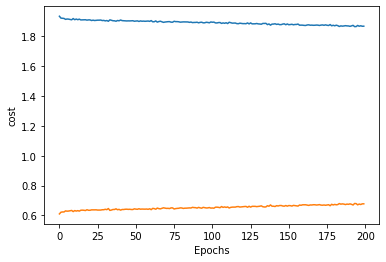

In [647]:
#plt.figure(figsize=(10,10))
plt.plot(resultado.history['loss'], label="Loss")
plt.plot(resultado.history['accuracy'], label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("cost")

## Conslusiones

La configuracion de los hiperparametros es compleja para lograr resultados altos en las metricas (accuracy, recall, etc) para dataset reales y no datos que se utilizan regularmente para el aprendizaje.  Desde una perspectiva de negocios esto requiere un gran esfuerzo desde todo momento; este proyecto requirio un parte fuerte de *Feature Engineering* lo cual fue muy costoso en tiempo.






Data Citation


1. Yu Zheng, Lizhu Zhang, Xing Xie, Wei-Ying Ma. Mining interesting locations and travel sequences from GPS trajectories. In Proceedings of International conference on World Wild Web (WWW 2009), Madrid Spain. ACM Press: 791-800.

2. Yu Zheng, Quannan Li, Yukun Chen, Xing Xie, Wei-Ying Ma. Understanding Mobility Based on GPS Data. In Proceedings of ACM conference on Ubiquitous Computing (UbiComp 2008), Seoul, Korea. ACM Press: 312-321

3. Yu Zheng, Xing Xie, Wei-Ying Ma, GeoLife: A Collaborative Social Networking Service among User, location and trajectory. Invited paper, in IEEE Data Engineering Bulletin. 33, 2, 2010, pp. 32-40.

